In [3]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_metrics(true_values, pred_values):
    mse = round(mean_squared_error(true_values, pred_values),3)
    mae = round(mean_absolute_error(true_values, pred_values),3)
    r_score = round(r2_score(true_values, pred_values),3)

    return {"mse": mse,
            "mae": mae,
            "r^2": r_score,}

In [2]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,49 mins 12 secs
H2O_cluster_timezone:,Europe/Kiev
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 12 days
H2O_cluster_name:,H2O_from_python_38066_njv82t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.852 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [19]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_logP_01.02_v3.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = []
X, y = dataPreparation.prepare_data_for_RF(is_pKa=False,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=False,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features or "angle" in feature_name:
        features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=False,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

train = h2o.H2OFrame(train_df)
test = h2o.H2OFrame(test_df)

True
183
['nC', 'FPSA3', 'nFARing', 'RPCS', 'dipole_moment', 'angle_R1X1R2', 'nFAHRing', 'angle_X2X1R1', 'nFHRing', 'naHRing', 'chirality', 'cis/trans', 'nHRing', 'TASA', 'angle_X1X2R2', 'nO', 'nF', 'PNSA5', 'dihedral_angle', 'f_atom_fraction', 'f_to_fg', 'nARing', 'angle_R2X2R1', 'identificator', 'naRing', 'nFaRing', 'nFaHRing', 'mol_volume', 'tpsa+f', 'mol_weight', 'avg_atoms_in_cycle', 'mol_num_cycles', 'nN', 'nAHRing', 'PBF', 'nFRing', 'WPSA5', 'f_freedom', 'distance_between_atoms_in_f_group_centers', 'PPSA5', 'GeomShapeIndex', 'pKa', 'logP']
dipole_moment [19, 21, 23, 27, 61, 66, 67, 73, 82, 136, 152, 182]
f_atom_fraction [124]
mol_volume [127]
distance_between_atoms_in_f_group_centers [168]
logP [82, 83]
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182],
      dtype='int64', length=183)
Remains rows:162, amount of features: 43
138 24
Parse progress: |████████████████████████████████████████████████████████

In [8]:
x = train.columns
# x.remove('C1')
y = "logP"
x.remove(y)

# train[y] = train[y].asfactor()
# test[y] = test[y].asfactor()

aml = H2OAutoML(seed=1, max_runtime_secs_per_model=300)
aml.train(x=x, y=y, training_frame=train, leaderboard_frame=test, fold_column="fold_id")

# View the AutoML Leaderboard
lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

AutoML progress: |█
17:43:45.502: Fold column fold_id will be used for cross-validation. nfolds parameter will be ignored.
17:43:45.522: AutoML: XGBoost is not available; skipping it.
17:43:45.576: _train param, Dropping bad and constant columns: [nN]
17:43:45.970: _train param, Dropping bad and constant columns: [nN]
17:43:45.970: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 138.0.
17:43:45.972: _train param, Dropping bad and constant columns: [nN]
17:43:47.60: _train param, Dropping bad and constant columns: [nN]
17:43:48.0: _train param, Dropping bad and constant columns: [nN]
17:43:48.588: _train param, Dropping bad and constant columns: [nN]
17:43:49.256: _train param, Dropping unused columns: [nN]
17:43:49.488: _train param, Dropping unused columns: [nN]
17:43:49.620: _train param, Dropping bad and constant columns: [nN]

██
17:43:50.435: _train param, Dropping bad and constant columns: [nN]
17

In [18]:
best_prev_model = h2o.load_model(r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\25.01.24_features\pKa\Only_mol_with_angles_without_outliers(except_dipole)_with_angles(as features)\DeepLearning_grid_3_AutoML_1_20240126_235839_model_3')

top_features = []
for feature_index in range(15):
    top_features.append(best_prev_model.varimp()[feature_index][0])
top_features

unimportant_features_to_drop = []
for feature_name in X.columns:
    if feature_name not in top_features:
        unimportant_features_to_drop.append(feature_name)

unimportant_features_to_drop

['dipole_moment',
 'nHRing',
 'avg_atoms_in_cycle',
 'angle_R2X2R1',
 'nF',
 'nFRing',
 'f_freedom',
 'mol_num_cycles',
 'nFAHRing',
 'distance_between_atoms_in_f_group_centers',
 'nC',
 'nAHRing',
 'mol_volume',
 'nFaRing',
 'nFHRing',
 'angle_X2X1R1',
 'nFaHRing',
 'RPCS',
 'naRing',
 'nFARing',
 'naHRing',
 'chirality',
 'nARing']

In [18]:
best_model = aml.get_best_model()
preds = best_model.predict(test)
true = test.as_data_frame()['logP']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.007, 'mae': 0.066, 'r^2': 0.97}

In [11]:
best_model

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_1_20240201_174345_model_87


Status of Neuron Layers: predicting logP, regression, gaussian distribution, Quadratic loss, 1 601 weights/biases, 25,7 KB, 1 381 380 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate               rate_rms               momentum    mean_weight           weight_rms           mean_bias              bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ----------------------  ---------------------  ----------  --------------------  -------------------  ---------------------  -----------------------
    1        30       Input             0.0
    2        50       RectifierDropout  40.0       0.0   0.0   0.0025706740690535903   0.0021276436746120453  0.0         0.017135965483340745  0.22171765565872192  -0.005726746662391851  0.3352932929992676
    3        1        Linear                       0.0   0.0   0.00013879622027161532  7.636877126060426e-05  0.0         0.02123679719865322   0.13471496105194092  0.0234126206831568     1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.007906777226365616
RMSE: 0.0889200608769788
MAE: 0.060686708056206955
RMSLE: 0.03709607013526567
Mean Residual Deviance: 0.007906777226365616

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 0.07623358511588307
RMSE: 0.2761043011542614
MAE: 0.21093493720451384
RMSLE: 0.09840965385871293
Mean Residual Deviance: 0.07623358511588307

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid
----------------------  ---------  ----------  ------------  ------------
mae                     0.210507   0.00521767  0.206818      0.214197
mean_residual_deviance  0.0770626  0.0101126   0.0842134     0.069912
mse                     0.0770626  0.0101126   0.0842134     0.069912
r2                      0.744631   0.08315     0.685835      0.803427
residual_deviance       0.0770626  0.0101126   0.0842134     0.069912
rmse                    0.277302   0.018234    0.290195      0.264409
rmsle                   0.0985455  0.00175058  0.0997833     0.0973076

Scoring History: 
    timestamp            duration          training_speed    epochs    iterations    samples      training_rmse    training_deviance    training_mae    training_r2
--  -------------------  ----------------  ----------------  --------  ------------  -----------  ---------------  -------------------  --------------  -------------
    2024-02-01 18:34:34  0.000 sec                           0         0             0            nan              nan                  nan             nan
    2024-02-01 18:34:34  55.510 sec        230000 obs/sec    10        1             1380         0.387465         0.150129             0.303032        0.528677
    2024-02-01 18:34:39  1 min  0.513 sec  231010 obs/sec    8380      838           1.15644e+06  0.0906536        0.00821807           0.0632366       0.9742
    2024-02-01 18:34:40  1 min  1.544 sec  228894 obs/sec    10010     1001          1.38138e+06  0.0889201        0.00790678           0.0606867       0.975177

Variable Importances: 
variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
mol_weight          1.0                    1.0                  0.046233510082397844
f_to_fg             0.9578854441642761     0.9578854441642761   0.0442864063405512
PPSA5               0.9222589731216431     0.9222589731216431   0.042639269532401367
cis/trans           0.8821896314620972     0.8821896314620972   0.04078672322078971
naRing              0.8488522171974182     0.8488522171974182   0.0392454175422626
WPSA5               0.8453095555305481     0.8453095555305481   0.039081627858368835
identificator       0.82356441

In [16]:
best_model = h2o.load_model(r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\01.02.24_features_2.1\pKa\all_molecules(without_angle_feature)_without_outliers\DeepLearning_grid_1_AutoML_3_20240201_153554_model_72')

preds = best_model.predict(test)
true = test.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.346, 'mae': 0.479, 'r^2': 0.943}

In [13]:
best_model

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_3_20240201_153554_model_72


Status of Neuron Layers: predicting pKa, regression, gaussian distribution, Quadratic loss, 601 weights/biases, 13,4 KB, 1 441 440 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms               momentum    mean_weight            weight_rms           mean_bias              bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  ---------------------  ----------  ---------------------  -------------------  ---------------------  -----------------------
    1        28       Input             0.0
    2        20       RectifierDropout  20.0       0.0   0.0   0.006155315171054099   0.003440672531723976   0.0         -0.003268691296865914  0.26069653034210205  -0.000600393816868855  0.3162055015563965
    3        1        Linear                       0.0   0.0   0.0010429051180835813  0.0007416477892547846  0.0         0.06576458439230919    0.21279138326644897  0.09533507739209846    1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.0393238220197905
RMSE: 0.19830235001076132
MAE: 0.14851573936886517
RMSLE: 0.025423154285872447
Mean Residual Deviance: 0.0393238220197905

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 0.6970048631135096
RMSE: 0.834868171098593
MAE: 0.5892955130760777
RMSLE: 0.0967235632146753
Mean Residual Deviance: 0.6970048631135096

Cross-Validation Metrics Summary: 
                        mean       sd           cv_1_valid    cv_2_valid
----------------------  ---------  -----------  ------------  ------------
mae                     0.587028   0.0288639    0.566618      0.607438
mean_residual_deviance  0.696608   0.00505348   0.693034      0.700181
mse                     0.696608   0.00505348   0.693034      0.700181
r2                      0.892001   0.00925112   0.898542      0.885459
residual_deviance       0.696608   0.00505348   0.693034      0.700181
rmse                    0.834628   0.00302738   0.832487      0.836768
rmsle                   0.0966803  0.000540983  0.0962978     0.0970629

Scoring History: 
    timestamp            duration           training_speed    epochs    iterations    samples      training_rmse    training_deviance    training_mae    training_r2
--  -------------------  -----------------  ----------------  --------  ------------  -----------  ---------------  -------------------  --------------  -------------
    2024-02-01 15:49:15  0.000 sec                            0         0             0            nan              nan                  nan             nan
    2024-02-01 15:49:15  13 min  6.839 sec  288000 obs/sec    10        1             1440         1.37902          1.9017               1.09862         0.706942
    2024-02-01 15:49:18  13 min  9.755 sec  493812 obs/sec    10010     1001          1.44144e+06  0.198302         0.0393238            0.148516        0.99394

Variable Importances: 
variable                                   relative_importance    scaled_importance    percentage
-----------------------------------------  ---------------------  -------------------  --------------------
PPSA5                                      1.0                    1.0                  0.10724933045144022
FPSA3                                      0.6533231735229492     0.6533231735229492   0.0700684729287464
nF                                         0.45250624418258667    0.45250624418258667  0.04853099171367834
nN                                         0.4461650252342224     0.4461650252342224   0.047850900227220286
PNSA5                                      0.4190134108066559     0.4190134108066559   0.044938907759188115
nFRing                                     0.3792937994003296     0.3792937994003296   0.04067900603006823
ide

PERMUTATION IMPORTANCE

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\38066\AppData\Local\Temp\ipykernel_21996\1575081460.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])


Text(0.5, 0, 'H2O Feature Importance')

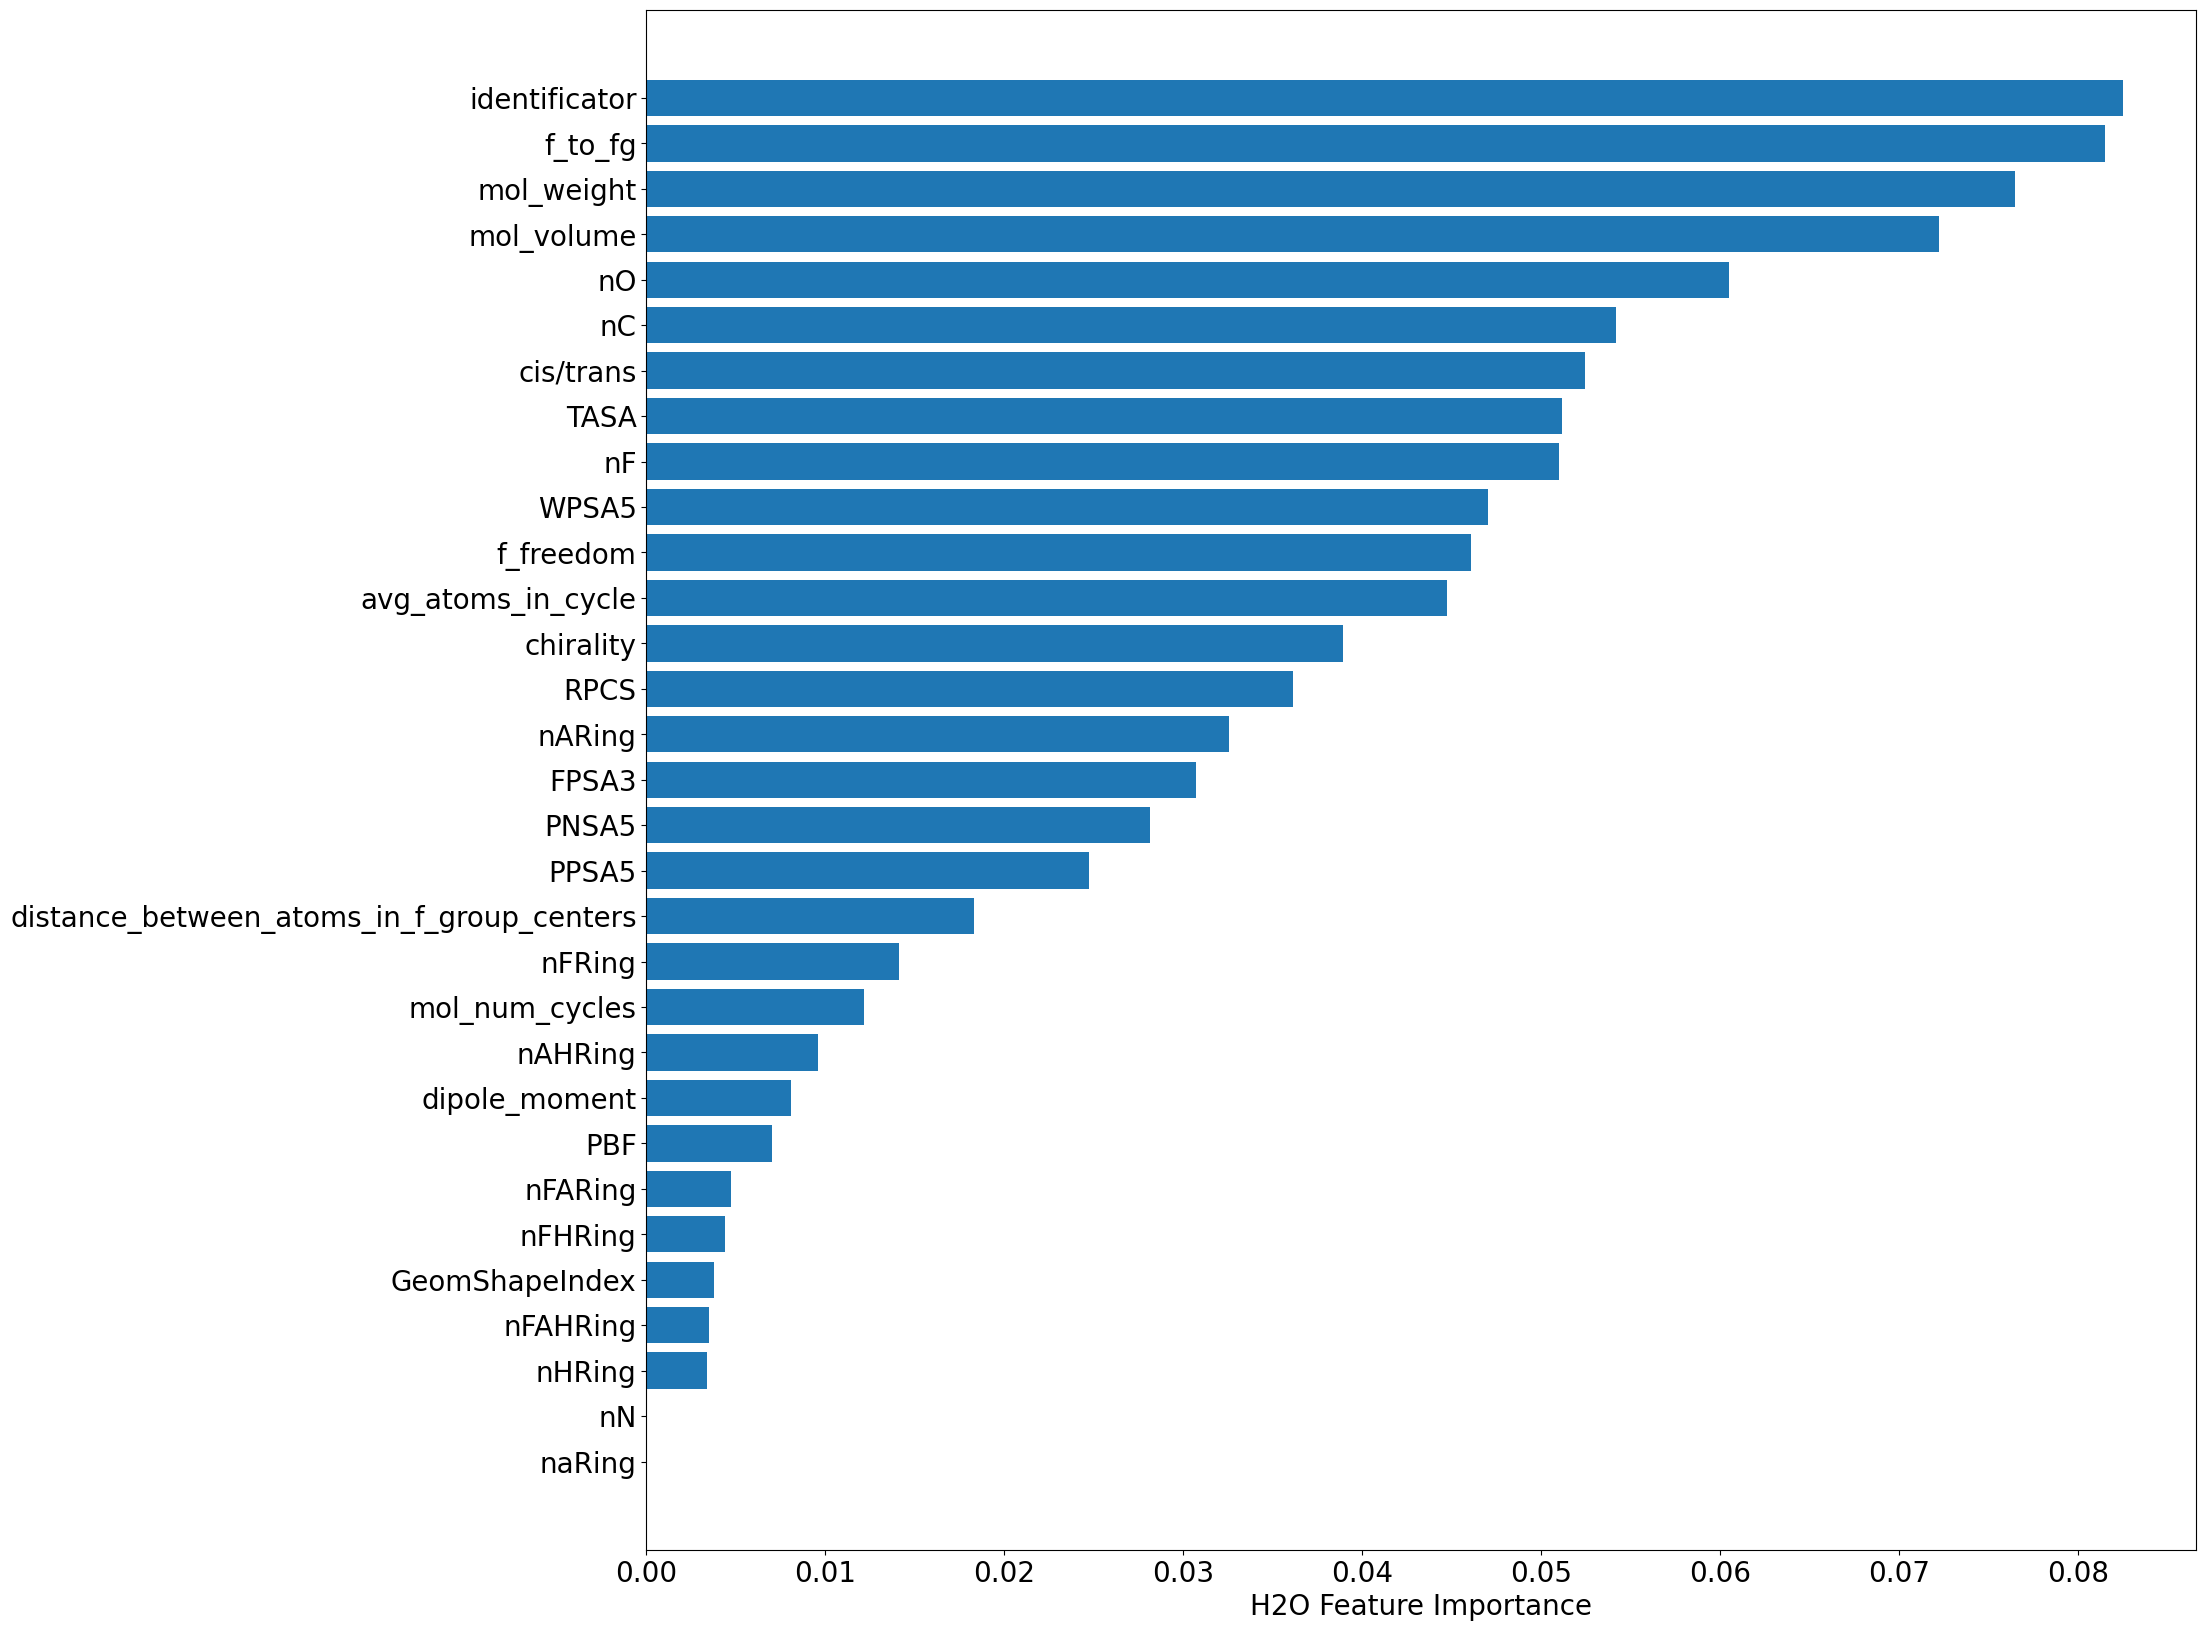

In [12]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

permutation_varimp = best_model.permutation_importance(test, use_pandas=True, n_repeats=1000)

sum_rows = permutation_varimp.sum(axis=1)
sum_rows = sum_rows / sum(sum_rows)

sorted_idx = sum_rows.argsort()
plt.figure(figsize=(20,20))
plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])
plt.xlabel("H2O Feature Importance")

SHAP

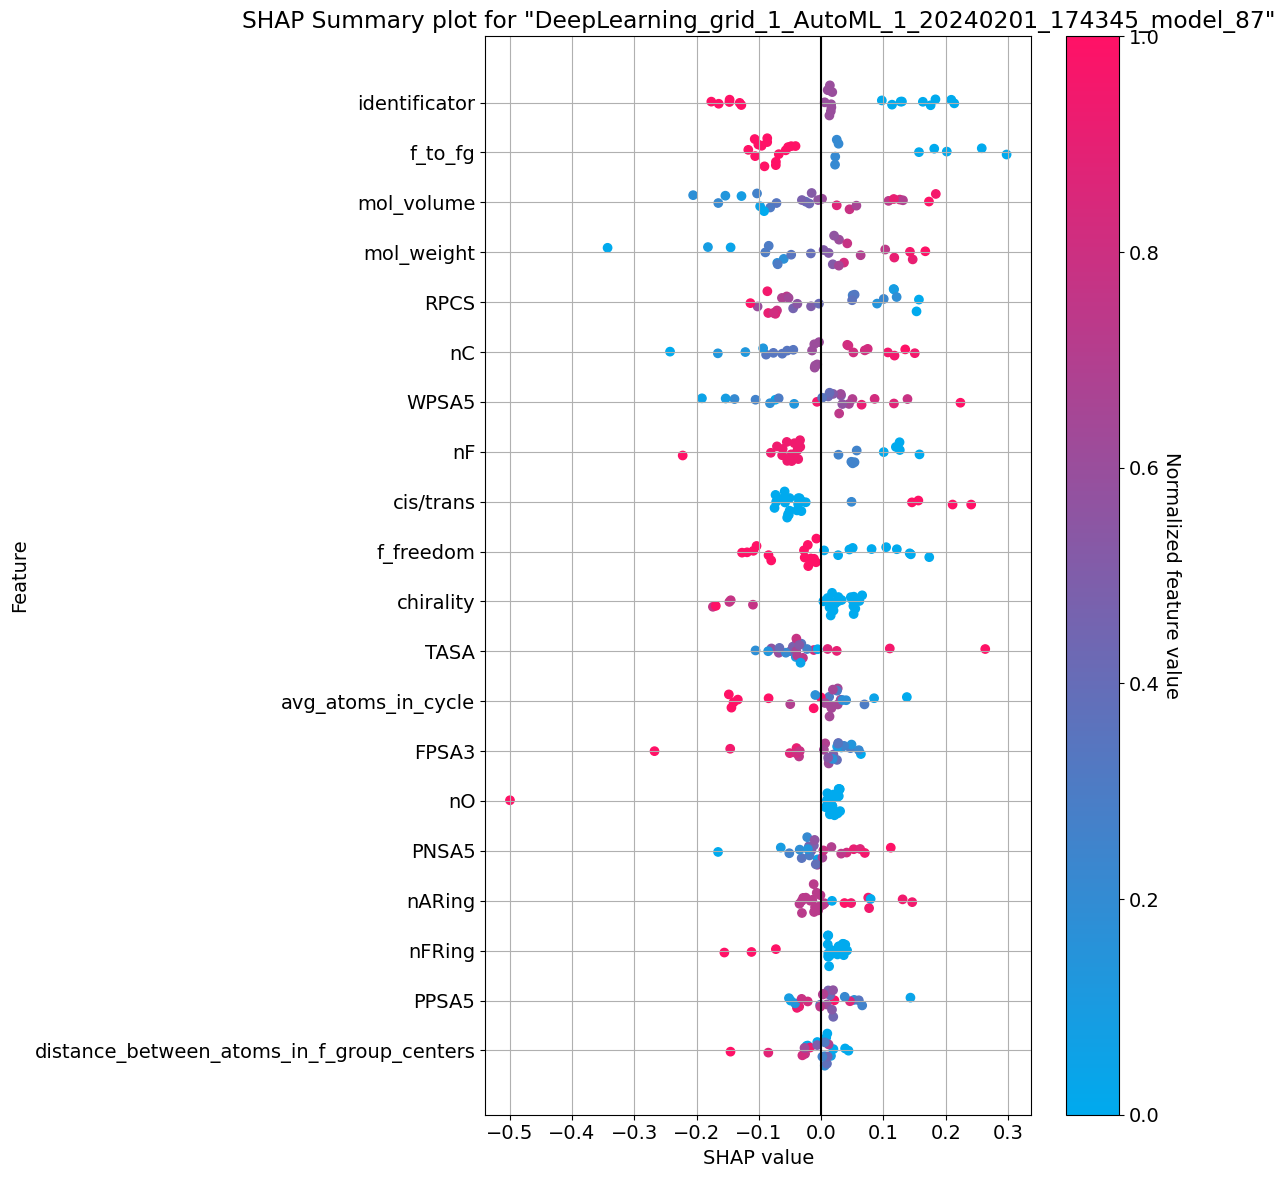

In [13]:
plt.rcParams.update({"font.size": 14})
shap_plot = best_model.shap_summary_plot(test, background_frame=train, samples=2000)

VAR IMPORTANCE

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Text(0.5, 0, 'Percent')

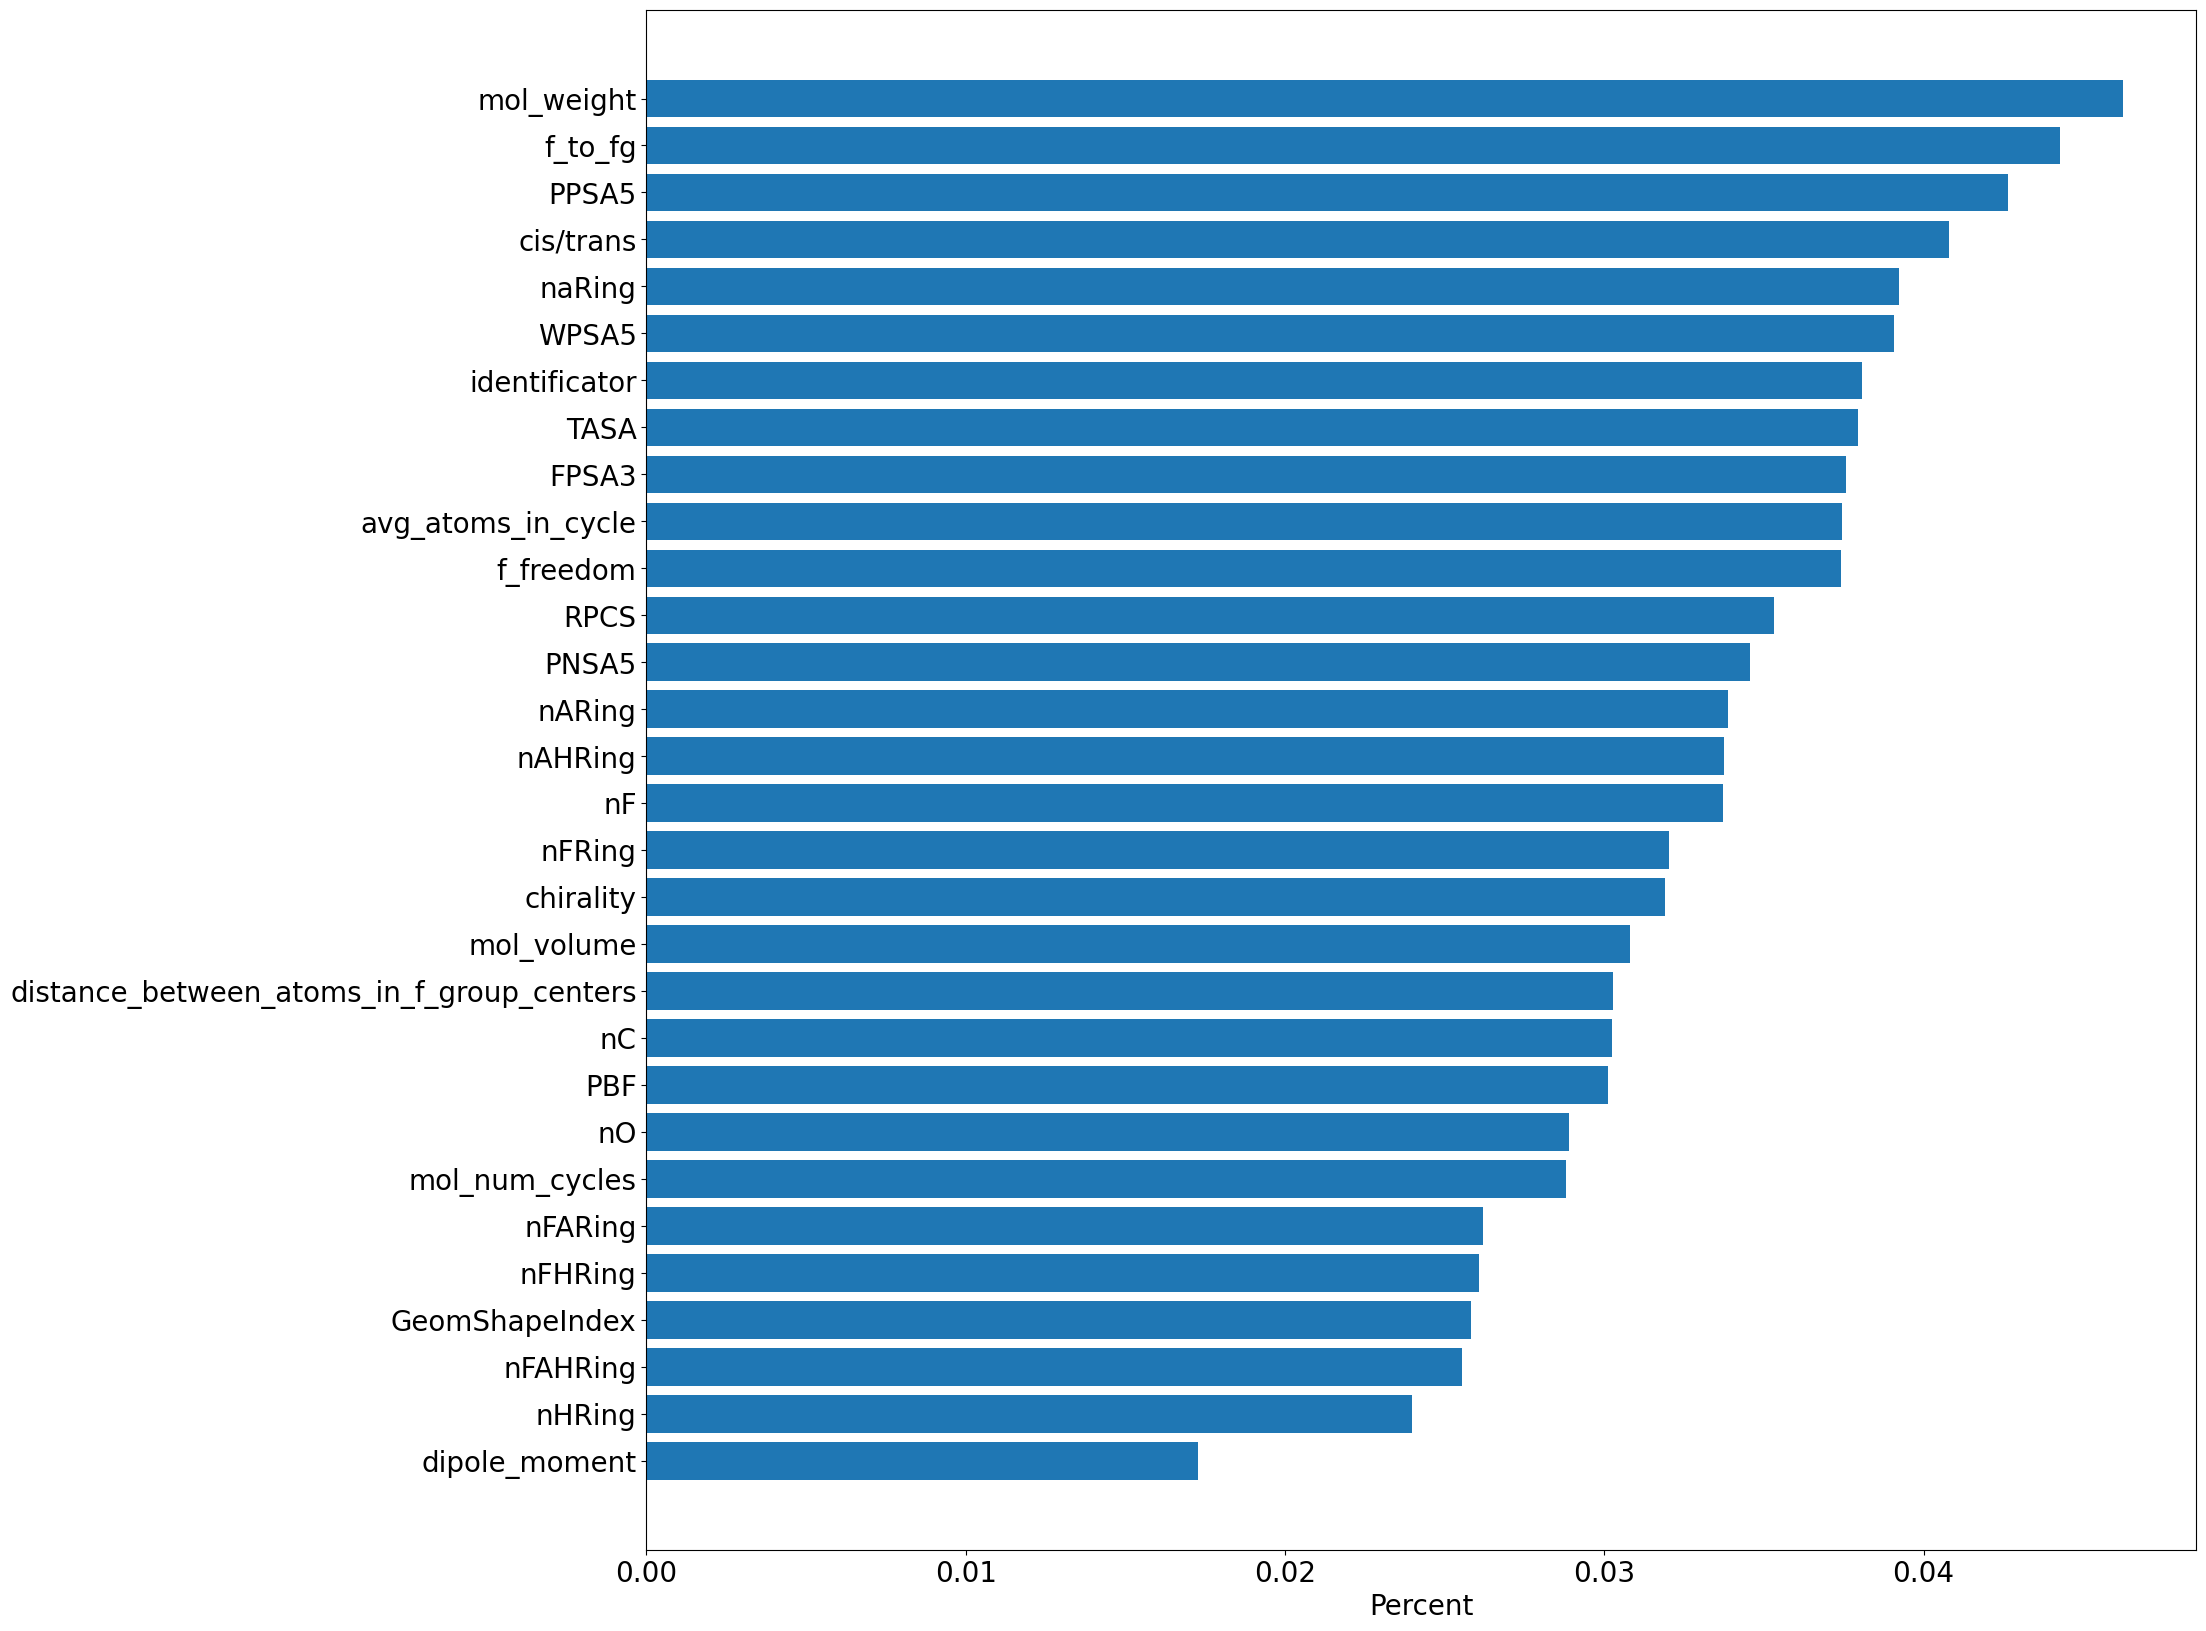

In [15]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

preds = best_model.predict(test)
true = test.as_data_frame()['logP']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

importance = best_model.varimp(test)

fig, ax = plt.subplots(figsize=(20, 20))
ax.barh(importance['variable'][:][::-1], importance['percentage'][:][::-1])
ax.set_xlabel('Percent')


BEST MODEL SAVING

In [16]:
import os

MODEL_SAVE_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\01.02.24_features_2.1\logP'

best_model = aml.get_best_model()

model_path = h2o.save_model(model=best_model, path=os.path.join(MODEL_SAVE_PATH, 'all_molecules(without_angle_feature)_without_outliers'), force=True)
model_path

'C:\\work\\DrugDiscovery\\main_git\\XAI_Chem\\ml_part\\h2o_model\\models\\01.02.24_features_2.1\\logP\\all_molecules(without_angle_feature)_without_outliers\\DeepLearning_grid_1_AutoML_1_20240201_174345_model_87'

In [19]:
best_model

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_3_20240201_153554_model_72


Status of Neuron Layers: predicting pKa, regression, gaussian distribution, Quadratic loss, 601 weights/biases, 13,4 KB, 1 441 440 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms               momentum    mean_weight            weight_rms           mean_bias              bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  ---------------------  ----------  ---------------------  -------------------  ---------------------  -----------------------
    1        28       Input             0.0
    2        20       RectifierDropout  20.0       0.0   0.0   0.006155315171054099   0.003440672531723976   0.0         -0.003268691296865914  0.26069653034210205  -0.000600393816868855  0.3162055015563965
    3        1        Linear                       0.0   0.0   0.0010429051180835813  0.0007416477892547846  0.0         0.06576458439230919    0.21279138326644897  0.09533507739209846    1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.0393238220197905
RMSE: 0.19830235001076132
MAE: 0.14851573936886517
RMSLE: 0.025423154285872447
Mean Residual Deviance: 0.0393238220197905

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 0.6970048631135096
RMSE: 0.834868171098593
MAE: 0.5892955130760777
RMSLE: 0.0967235632146753
Mean Residual Deviance: 0.6970048631135096

Cross-Validation Metrics Summary: 
                        mean       sd           cv_1_valid    cv_2_valid
----------------------  ---------  -----------  ------------  ------------
mae                     0.587028   0.0288639    0.566618      0.607438
mean_residual_deviance  0.696608   0.00505348   0.693034      0.700181
mse                     0.696608   0.00505348   0.693034      0.700181
r2                      0.892001   0.00925112   0.898542      0.885459
residual_deviance       0.696608   0.00505348   0.693034      0.700181
rmse                    0.834628   0.00302738   0.832487      0.836768
rmsle                   0.0966803  0.000540983  0.0962978     0.0970629

Scoring History: 
    timestamp            duration           training_speed    epochs    iterations    samples      training_rmse    training_deviance    training_mae    training_r2
--  -------------------  -----------------  ----------------  --------  ------------  -----------  ---------------  -------------------  --------------  -------------
    2024-02-01 15:49:15  0.000 sec                            0         0             0            nan              nan                  nan             nan
    2024-02-01 15:49:15  13 min  6.839 sec  288000 obs/sec    10        1             1440         1.37902          1.9017               1.09862         0.706942
    2024-02-01 15:49:18  13 min  9.755 sec  493812 obs/sec    10010     1001          1.44144e+06  0.198302         0.0393238            0.148516        0.99394

Variable Importances: 
variable                                   relative_importance    scaled_importance    percentage
-----------------------------------------  ---------------------  -------------------  --------------------
PPSA5                                      1.0                    1.0                  0.10724933045144022
FPSA3                                      0.6533231735229492     0.6533231735229492   0.0700684729287464
nF                                         0.45250624418258667    0.45250624418258667  0.04853099171367834
nN                                         0.4461650252342224     0.4461650252342224   0.047850900227220286
PNSA5                                      0.4190134108066559     0.4190134108066559   0.044938907759188115
nFRing                                     0.3792937994003296     0.3792937994003296   0.04067900603006823
ide

In [17]:
test_df

,avg_atoms_in_cycle,chirality,PPSA5,RPCS,mol_num_cycles,GeomShapeIndex,nN,distance_between_atoms_in_f_group_centers,nC,nFARing,...,nARing,nF,nAHRing,nO,TASA,mol_volume,FPSA3,PNSA5,nHRing,pKa
26,0.0,0,14.658366,16.590193,0,0.459796,0,0.000000,5,0,...,0,2,0,2,129.249891,118.34,0.044389,-34.120596,0,3.55
53,2.5,0,16.455047,27.417416,2,0.742680,0,0.933217,6,0,...,2,2,0,2,125.163042,119.14,0.045887,-33.215687,0,3.51
18,4.0,0,13.476809,21.306553,1,0.883250,0,1.155412,5,0,...,1,2,0,2,96.522239,109.54,0.046176,-43.762810,0,4.02
36,3.5,0,14.159698,22.806203,2,0.773356,0,1.520132,8,0,...,2,2,0,2,152.956231,148.75,0.040798,-29.008005,0,4.35
22,6.0,0,14.044210,24.924560,1,0.894953,0,1.645098,7,0,...,1,2,0,2,146.940376,139.52,0.043610,-30.254001,0,4.18
52,2.5,0,15.401796,18.180349,2,0.919507,0,0.000000,6,0,...,2,0,0,2,185.219675,108.96,0.048901,-16.082304,0,4.61
154,6.0,0,10.360490,0.000000,1,0.513970,1,4.464055,6,0,...,1,2,0,0,200.084128,122.46,0.033363,-16.320349,0,9.12
168,3.5,0,10.279217,1.869556,2,0.814447,1,6.444383,7,0,...,2,2,0,0,201.849049,132.63,0.029960,-16.347813,0,9.58
162,3.0,0,7.909767,84.836969,1,0.839966,1,0.000000,3,0,...,1,0,0,0,190.597796,67.22,0.040995,-7.196423,0,8.76
104,4.0,0,10.588537,107.940433,1,0.631338,1,0.000000,5,0,...,1,1,0,0,212.346295,103.30,0.041355,-10.255848,0,8.10
